# Benchmarking

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from challenger_pydocker import ChallengeR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from htc.evaluation.metrics.scores import normalize_grouped_cm
from htc.evaluation.model_comparison.paper_runs import collect_comparison_runs, model_comparison_table
from htc.evaluation.model_comparison.run_challengeR_table import challengeR_table
from htc.fonts.set_font import set_font
from htc.rater_variability.rater_evaluation import rater_evaluation
from htc.settings import settings
from htc.settings_seg import settings_seg
from htc.utils.Config import Config
from htc.utils.helper_functions import sort_labels_cm
from htc.utils.LabelMapping import LabelMapping

set_font()
import plotly.io as pio

pio.kaleido.scope.mathjax = None

In [2]:
settings_seg.model_comparison_timestamp

'2022-02-03_22-58-44'

## Box Plots

In [3]:
rater_metrics = rater_evaluation("semantic#inter1")[0]
df_runs = collect_comparison_runs(settings_seg.model_comparison_timestamp)
metrics = ["confusion_matrix", "dice_metric_image", "surface_distance_metric_image", settings_seg.nsd_aggregation]

df_val = model_comparison_table(df_runs, test=False, metrics=metrics)
df_test = model_comparison_table(df_runs, test=True, metrics=metrics)
for modality_old, modality_new in settings_seg.modality_names.items():
    df_test["model_type"] = df_test["model_type"].str.replace(modality_old, modality_new)
    df_val["model_type"] = df_val["model_type"].str.replace(modality_old, modality_new)
df_val["model_name"] = df_val["model_name"].str.replace("superpixel_classification", "superpixel")
df_test["model_name"] = df_test["model_name"].str.replace("superpixel_classification", "superpixel")

[INFO][htc] P041#2019_12_14_13_33_30: There are 963 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P041#2019_12_14_13_33_30: Additional labels by the rater: ['peritoneum']              rater_evaluation.py:52

[INFO][htc] P043#2019_12_20_10_08_40: There are 175 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P045#2020_02_05_10_58_01: There are 1024 pixels different in the mask files           rater_evaluation.py:39

[INFO][htc] P046#2020_02_07_09_15_26: There are 265 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P047#2020_02_07_17_28_15: There are 260 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P048#2020_02_08_10_42_38: There are 174 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P048#2020_02_08_10_42_38: Labels missing by the rater: ['gallbladder']                rater_evaluation.py:55

[INFO][htc] P049#2020_02_11_19_11_58: There are 2996 pixels different in the mask files           rater_evaluation.py:39

[INFO][htc] P050#2020_02_18_18_14_43: There are 912 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P057#2020_03_13_18_53_29: There are 3098 pixels different in the mask files           rater_evaluation.py:39

[INFO][htc] P058#2020_05_13_18_29_23: Additional labels by the rater: ['fat', 'spleen']           rater_evaluation.py:52

[INFO][htc] P058#2020_05_13_18_29_23: Labels missing by the rater: ['liver']                      rater_evaluation.py:55

[INFO][htc] P059#2020_05_14_13_00_45: Additional labels by the rater: ['fat', 'peritoneum',       rater_evaluation.py:52
'skin']                                                                                                                 

[INFO][htc] P059#2020_05_14_13_00_45: Labels missing by the rater: ['stomach']                    rater_evaluation.py:55

[INFO][htc] P060#2020_05_14_19_37_53: There are 691 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P060#2020_05_14_19_37_53: Labels missing by the rater: ['major_vein']                  rater_evaluation.py:55

[INFO][htc] P061#2020_05_15_10_53_49: There are 19259 pixels different in the mask files          rater_evaluation.py:39

[INFO][htc] P061#2020_05_15_10_53_49: Additional labels by the rater: ['spleen']                  rater_evaluation.py:52

[INFO][htc] P062#2020_05_15_22_02_05: There are 426 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P068#2020_07_20_18_13_09: Labels missing by the rater: ['omentum', 'peritoneum']      rater_evaluation.py:55

[INFO][htc] P069#2020_07_23_10_22_54: There are 616 pixels different in the mask files            rater_evaluation.py:39

[INFO][htc] P072#2020_08_08_12_55_39: There are 3204 pixels different in the mask files           rater_evaluation.py:39

[INFO][htc] P072#2020_08_08_12_55_39: Additional labels by the rater: ['spleen']                  rater_evaluation.py:52

[INFO][htc] P072#2020_08_08_12_55_39: Labels missing by the rater: ['liver']                      rater_evaluation.py:55

[INFO][htc] 8 total additional labels: ['fat', 'fat', 'peritoneum', 'peritoneum', 'skin',         rater_evaluation.py:63
'spleen', 'spleen', 'spleen']                                                                                           

[INFO][htc] 7 total missing labels: ['gallbladder', 'liver', 'liver', 'omentum', 'peritoneum',    rater_evaluation.py:65
'stomach', 'major_vein']                                                                                                 

[INFO][htc] 14: total pixel difference in the masks: 34063                                        rater_evaluation.py:67

In [4]:
def create_model_comparison(df: pd.DataFrame, metric: str, metric_name: str) -> go.Figure:
    fig = px.box(
        df, x="model_name", y=metric, color="model_type", points="all", color_discrete_map=settings_seg.modality_colors
    )
    fig.update_traces(boxmean=True)

    mean = rater_metrics[metric].mean()
    std = rater_metrics[metric].std()
    fig.add_hline(y=mean, line_dash="dash", line_color="gray")
    fig.add_hrect(y0=mean - std, y1=mean + std, line_width=0, fillcolor="gray", opacity=0.1)

    fig.layout.height = 400
    fig.layout.width = 1000

    fig.update_layout(xaxis_title="<b>model</b>", yaxis_title=f"<b>{metric_name}</b>")
    fig.update_layout(legend=dict(title=None, orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5))
    fig.update_layout(
        template="plotly_white", font_family="Libertinus Serif", font_size=22, margin=dict(l=0, r=0, b=0, t=0)
    )

    if metric != "dice_metric_image":
        fig.update_layout(showlegend=False)

    return fig

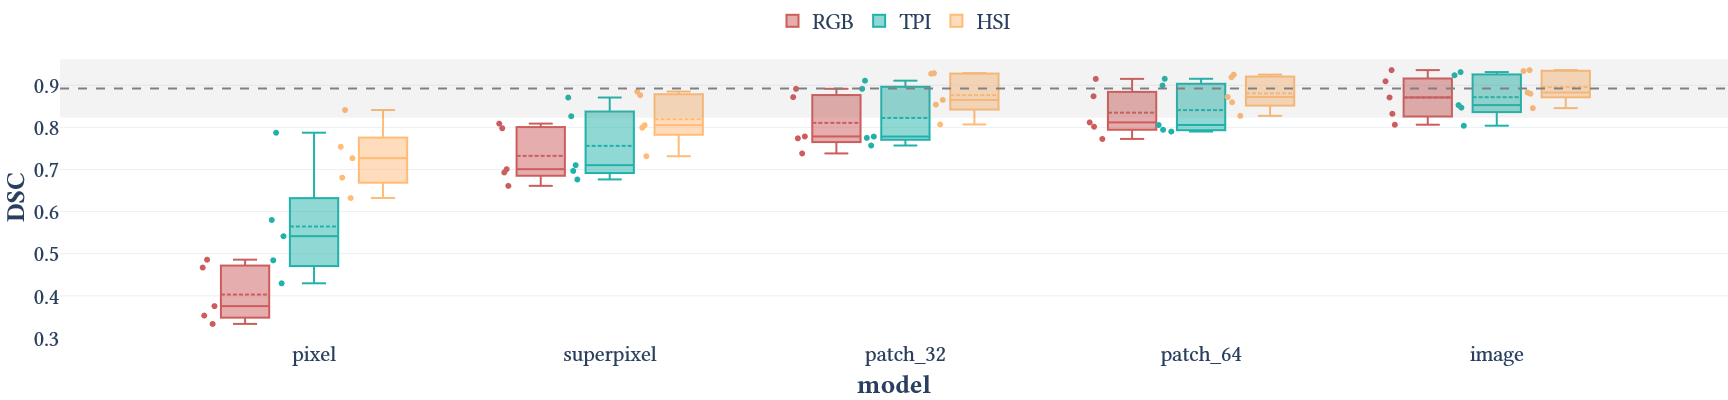

In [5]:
create_model_comparison(df_test, "dice_metric_image", "DSC")
# Manual adjustments:
# - Update link in *DSC_adjusted.pdf files

In [6]:
for df, set_name in [(df_test, "test"), (df_val, "val")]:
    for metric, metric_name in [
        ("dice_metric_image", "DSC"),
        ("surface_distance_metric_image", "ASD"),
        (settings_seg.nsd_aggregation, "NSD"),
    ]:
        fig = create_model_comparison(df, metric, metric_name)
        fig.write_image(settings_seg.paper_dir / f"benchmarking_box_{set_name}_{metric_name}.pdf")

## Ranking

In [7]:
def get_rank_data(df: pd.DataFrame, set_type: str, metrics: list[str]) -> dict[str, pd.DataFrame]:
    with ChallengeR() as c:
        c.add_data_matrix(df)
        c.create_challenge(algorithm="algorithm", case="case_id", value="metric_value", task="metric", smallBetter=True)

        for metric in metrics:
            # Also export rank stability plot
            # Based on: https://github.com/wiesenfa/challengeR/blob/master/inst/appdir/visualizationBlobPlots.Rmd
            c.run_r(
                f"""
                a=list(bootsrappedRanks=list(rankingBootstrapped$bootsrappedRanks[["{metric}"]]),
                       matlist=list(rankingBootstrapped$matlist[["{metric}"]]))
                names(a$bootsrappedRanks)=names(a$matlist)="{metric}"
                class(a)="bootstrap.list"
                r=rankingBootstrapped$matlist[["{metric}"]]
            """
            )
            c.save_figure(
                (
                    "theme_set(theme_light()); stabilityByTask(a, ordering=rownames(r[order(r$rank),]),"
                    " size.ranks=.25*theme_get()$text$size, max_size=7, size=7, shape=4) + guides(color=FALSE)"
                ),
                settings_seg.paper_dir / f"ranking_bootstrapped_{set_type}_{metric}.pdf",
            )
            # Manual adjustments
            # - Make sure the ranking matches with the challengeR report
            # - Copy and adjust (font, size) ranking numbers on the x-axis
            # - Delete everything from the new pdf which is not needed because it is already there (e.g. legend)
            # - Maybe re-order symbols and text on x-axis
            # - Recolor blobs

        rank_data = {
            "DSC": c.get_df("ranking$matlist$dice_metric_image"),
            "ASD": c.get_df("ranking$matlist$surface_distance_metric_image"),
            "NSD": c.get_df(f"ranking$matlist${settings_seg.nsd_aggregation}"),
        }

    return rank_data


metrics = ["dice_metric_image", "surface_distance_metric_image", settings_seg.nsd_aggregation]
ranks_test = get_rank_data(challengeR_table(metrics=metrics, test=True), "test", metrics)

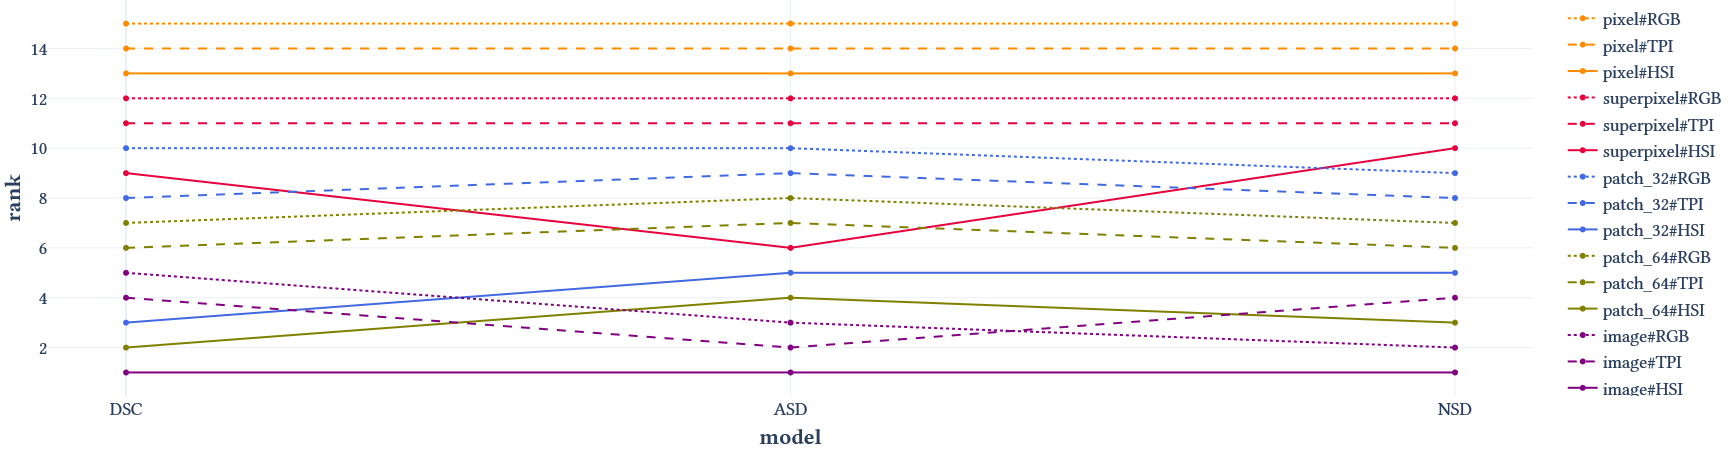

In [8]:
def rank_nsd_figure(rank_data: dict[str, pd.DataFrame]) -> go.Figure:
    rownames = None
    for r in rank_data.values():
        if rownames is None:
            rownames = r["rowname"]
        else:
            assert all(rownames == r["rowname"])

    fig = go.Figure()

    line_style = {
        "HSI": "solid",
        "TPI": "dash",
        "RGB": "dot",
    }
    models = list(settings_seg.model_colors.keys())
    x = list(range(len(rank_data)))

    for model in models:
        for modality in reversed(settings_seg.modality_names.values()):
            model_short = model.replace("superpixel_classification", "superpixel")
            name = f"{model_short}#{modality}"
            y = [r.query(f'rowname == "{name}"')["rank"].item() for r in rank_data.values()]

            fig.add_trace(
                go.Scatter(
                    x=x, y=y, name=name, marker_color=settings_seg.model_colors[model], line_dash=line_style[modality]
                )
            )

    fig.layout.width = 650
    fig.layout.height = 450
    fig.update_layout(xaxis=dict(tickmode="array", tickvals=x, ticktext=list(rank_data.keys())))
    fig.update_layout(xaxis_title="<b>model</b>", yaxis_title="<b>rank</b>")
    fig.update_layout(
        template="plotly_white", font_family="Libertinus Serif", font_size=18, margin=dict(l=0, r=0, b=0, t=0)
    )

    return fig


fig = rank_nsd_figure(ranks_test)
fig.write_image(settings_seg.paper_dir / "ranking_stability_metrics.pdf")
# Manual adjustments
# - Use legend with symbols
fig

## Confusion Matrix

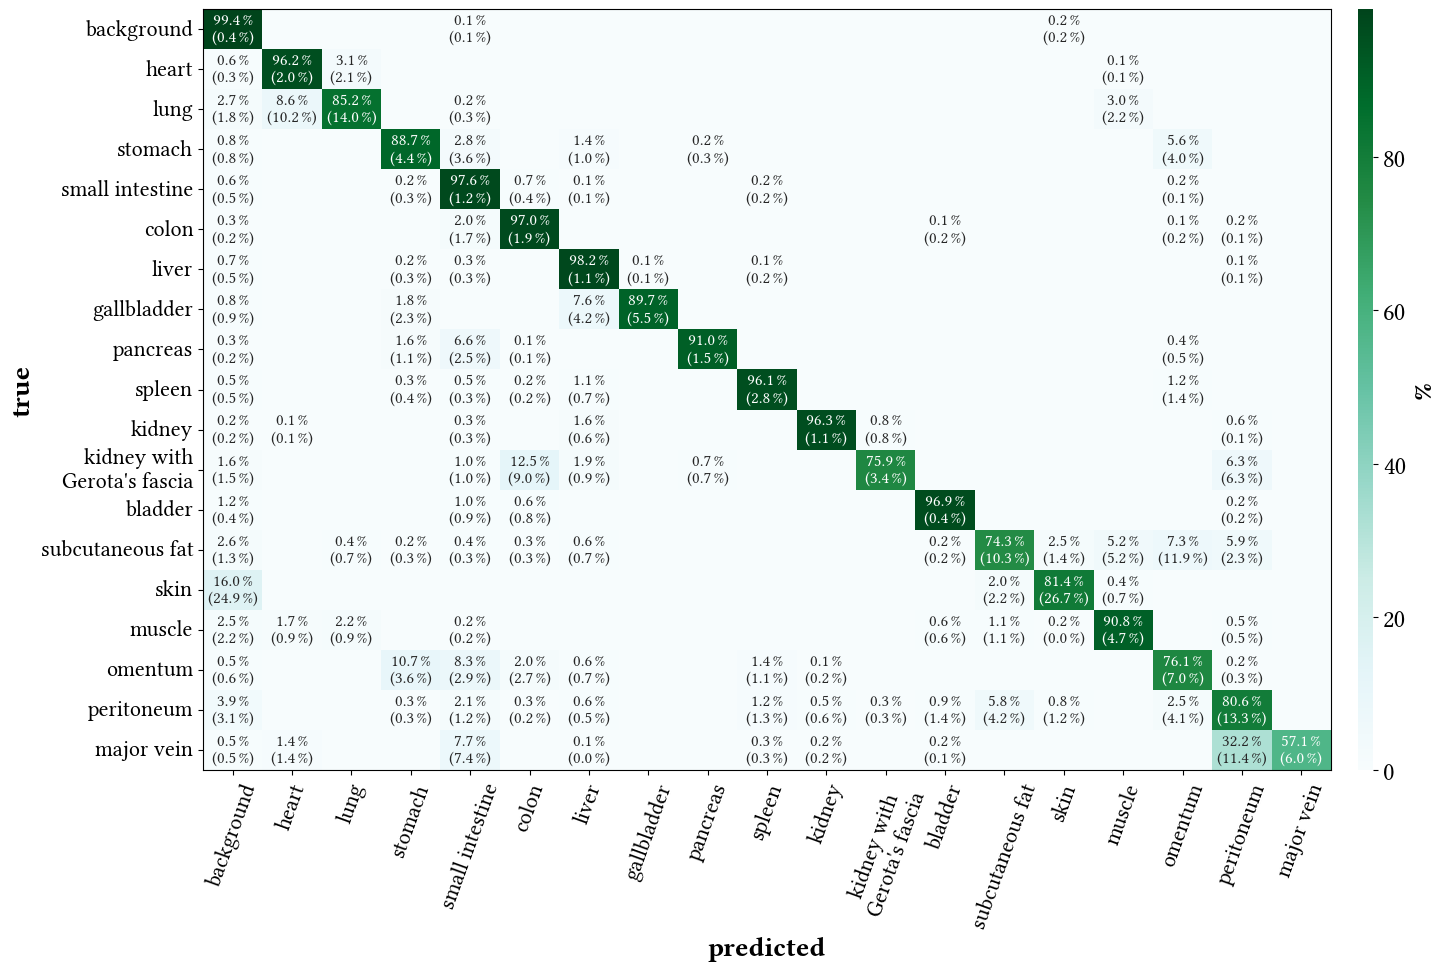

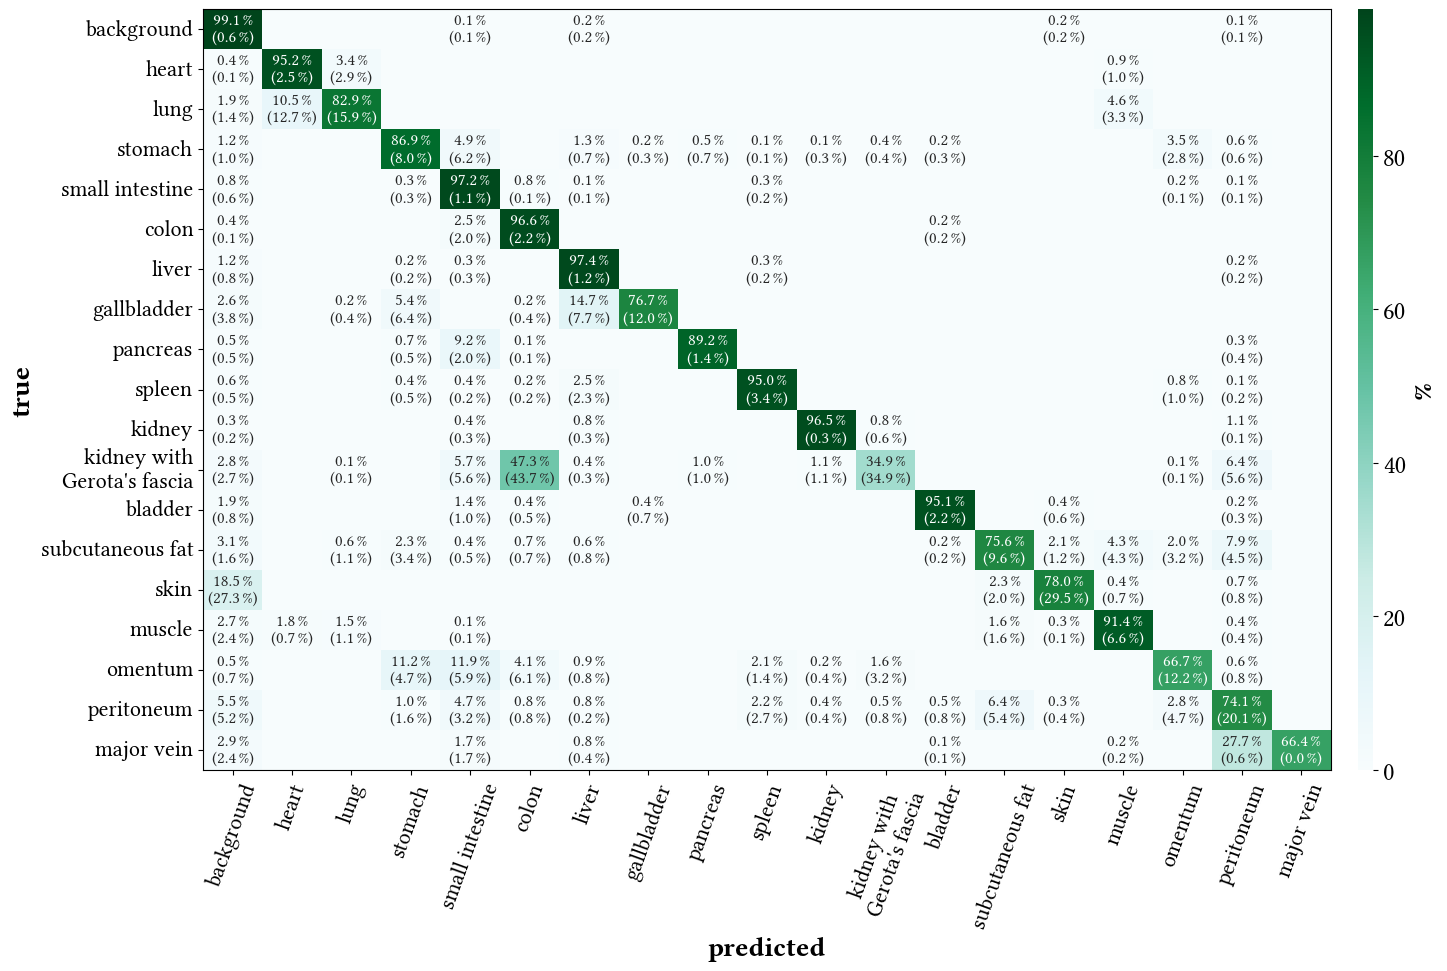

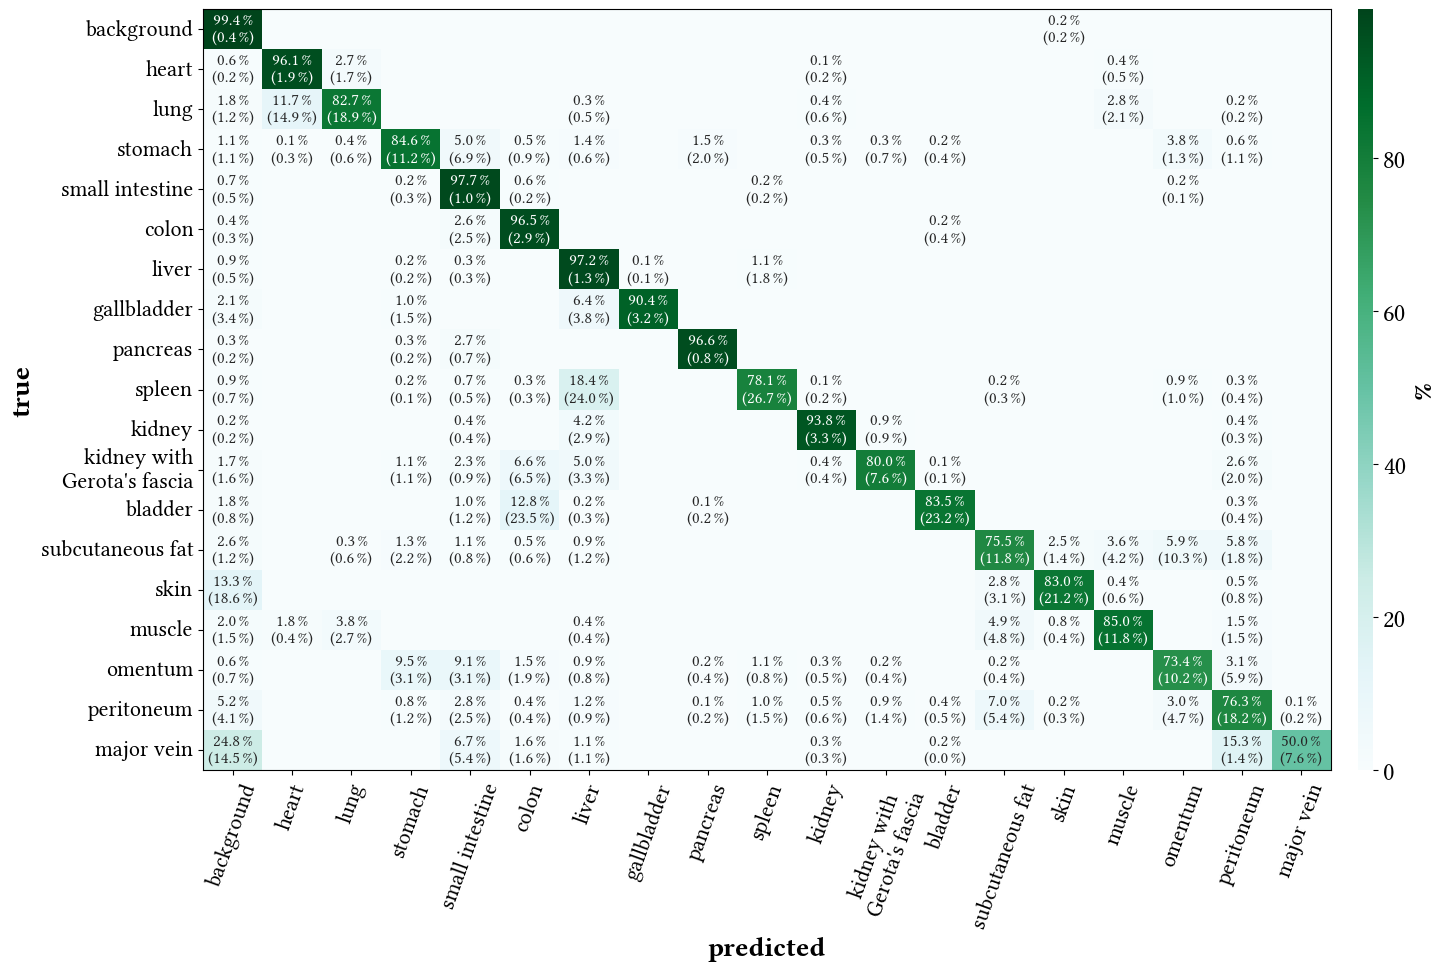

In [9]:
# We need the config for the labels
def cm_modality(modality_old: str, modality_new: str) -> plt.Figure:
    run_dir = settings.training_dir / "image" / df_runs.query('model == "image"')[f"run_{modality_old}"].item()
    config = Config(run_dir / "config.json")
    mapping = LabelMapping.from_config(config)
    labels = [l for l in settings_seg.label_colors_paper.keys() if l in mapping.label_names()]

    labels_mpl = [settings_seg.labels_paper_renaming.get(l, l) for l in labels]
    labels_mpl = [l.replace("<br>", "\n") for l in labels_mpl]

    # Normalize cm (per pig and then average)
    cm_stacked = np.stack(
        df_test.query('model_name == "image" and model_type == @modality_new')["confusion_matrix"].values
    )

    # Normalize the cm
    cm_rel, cm_rel_std = normalize_grouped_cm(cm_stacked)
    cm_rel *= 100
    cm_rel_std *= 100

    cm_rel = sort_labels_cm(cm_rel, cm_order=mapping.label_names(), target_order=labels)
    cm_rel_std = sort_labels_cm(cm_rel_std, cm_order=mapping.label_names(), target_order=labels)

    # confusion matrix with relative numbers
    fig, ax = plt.subplots(tight_layout=True, figsize=(16, 10), dpi=100, edgecolor="k")

    text = np.vectorize(lambda x_rel, x_rel_std: "" if x_rel < 0.1 else f"{x_rel:.1f} %\n({x_rel_std:.1f} %)")(
        cm_rel, cm_rel_std
    )
    res = sns.heatmap(
        cm_rel,
        annot=text,
        annot_kws={"size": 12},
        fmt="s",
        xticklabels=labels_mpl,
        yticklabels=labels_mpl,
        cmap="BuGn",
        cbar_kws={"aspect": 50, "pad": 0.02},
    )

    # Make frame visible
    for _, spine in res.spines.items():
        spine.set_color("k")
        spine.set_visible(True)

    cbar_axes = ax.figure.axes[-1]
    cbar_axes.tick_params(labelsize=18)
    cbar_axes.yaxis.label.set_size(20)
    cbar = ax.collections[0].colorbar
    cbar.set_label("%", fontweight="bold")

    for i, t in enumerate(ax.xaxis.get_ticklabels()):
        t.set_rotation(70)

    plt.ylabel("true", fontweight="bold", fontsize=20)
    plt.xlabel("predicted", fontweight="bold", fontsize=20)
    ax.tick_params(axis="both", labelsize=16)

    return fig


for modality_old, modality_new in settings_seg.modality_names.items():
    fig = cm_modality(modality_old, modality_new)
    fig.savefig(settings_seg.paper_dir / f"cm_{modality_new}.pdf", bbox_inches="tight")

## Direct comparison between modalities startified by organ

In [10]:
label_ordering = settings_seg.label_mapping.label_names()
label_ordering = [settings_seg.labels_paper_renaming.get(l, l) for l in label_ordering]
organs = []

for model_type in df_test.model_type.unique():
    for subject_name in df_test.subject_name.unique():
        cm = df_test.query('model_name == "image" and model_type == @model_type and subject_name == @subject_name')[
            "confusion_matrix"
        ].item()
        with np.errstate(invalid="ignore"):
            normalized_cm = cm / np.sum(cm, axis=1, keepdims=True)
        recalls = normalized_cm.diagonal()
        for i, acc in enumerate(recalls):
            organs.append([model_type, subject_name, label_ordering[i], acc])

df_organs = pd.DataFrame(organs, columns=["modality", "subject_name", "organ", "recall"])

In [11]:
label_paper_order = [l for l in settings_seg.label_colors_paper.keys() if l in settings_seg.label_mapping.label_names()]
label_paper_order = [settings_seg.labels_paper_renaming.get(l, l) for l in label_paper_order]
fig = px.box(
    df_organs,
    x="organ",
    y="recall",
    color="modality",
    points="all",
    color_discrete_map=settings_seg.modality_colors,
    category_orders={"organ": label_paper_order},
)
fig.update_traces(boxmean=True)

fig.layout.height = 400
fig.layout.width = 1500
fig.update_layout(xaxis_title="<b>organ</b>", yaxis_title="<b>recall</b>")
fig.update_layout(legend=dict(title=None, orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5))
fig.update_layout(
    template="plotly_white", font_family="Libertinus Serif", font_size=18, margin=dict(l=0, r=0, b=0, t=0)
)
fig.update_xaxes(range=[-0.6, len(label_paper_order) - 1 + 0.6])
fig.write_image(settings_seg.paper_dir / "recall_per_organ.pdf")

## Graphical Abstract Idea

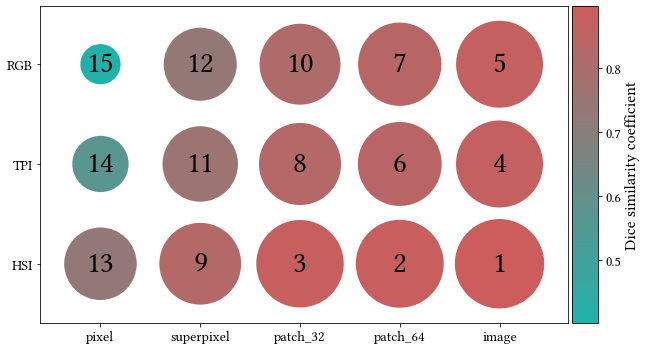

In [12]:
models = [k.replace("_classification", "") for k in settings_seg.model_colors.keys()]
modalities = list(settings_seg.modality_names.values())
ranking = ranks_test["DSC"]
ranking["dice"] = ranking["metric_value_mean"].apply(lambda x: 1 - float(x.replace(",", ".")))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# cmap = plt.colormaps.get_cmap('summer_r')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("own", ["lightseagreen", "indianred"])
cnorm = matplotlib.colors.Normalize(vmin=ranking["dice"].min(), vmax=ranking["dice"].max())

for i, row in ranks_test["DSC"].iterrows():
    model, modality = row["rowname"].split("#")
    rank = row["rank"]
    x = models.index(model)
    y = modalities.index(modality)

    circle = plt.Circle((x, y), radius=row["dice"] * 0.5, facecolor=cmap(cnorm(row["dice"])))
    ax.add_patch(circle)
    ax.annotate(rank, xy=(x, y), fontsize=30, verticalalignment="center", horizontalalignment="center")

# ax.axis('off')
ax.set_aspect("equal")
ax.autoscale_view()
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models)
ax.set_yticks(range(len(modalities)))
ax.set_yticklabels(modalities)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(plt.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax)
cax.set_ylabel("Dice similarity coefficient")
fig.savefig(settings_seg.paper_dir / "graphical_abstract_ranking.pdf")